# Mass Balance 

In [1]:
import numpy as np
import xarray as xr
from scipy import interpolate
import matplotlib.pyplot as plt 

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})



def constant_spline(z, tck, z_max=3500): 
    # z below z_max
    z_b = z[np.where(z<z_max)]
    # B below z_max
    b_b = interpolate.splev(z_b, tck)
    # B full
    b_f = np.concatenate((b_b, np.ones(z.size-b_b.size)*b_b[-1]))
    return b_f

In [2]:
nc_fp = "/Users/andrewnolan/Library/CloudStorage/OneDrive-SimonFraserUniversity(1sfu)/KMR_debrisfree_NetBalance/Kaskawulsh_NetBalance_with_DailyTemp.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    pass


x = MB_new.stack(z=('x', 'y')).Z.values
y = MB_new.stack(z=('x', 'y')).B.values

# find indexes of nans and sort indexes
mask = np.where(~np.isnan(x))
idxs = np.argsort(x[mask])

# Remove the nans and sort the data and downsample data so there are
# less verically overlappig points, causing the spline fitting to fail
x_sub = x[~np.isnan(x)]
y_sub = y[~np.isnan(x)]

idxs   = np.argsort(x_sub, kind='heapsort')
x_     = x_sub[idxs]
y_     = y_sub[idxs]
z_full = np.linspace(-250, 5e3, 1000)

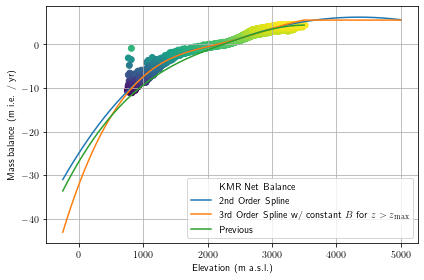

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharex=True)

old_z = np.loadtxt('../include/fitpack/test/data/x_vec.dat')
old_b = np.loadtxt('../include/fitpack/test/data/y_vec.dat')

ax.scatter(MB_new.Z, MB_new.B, c=MB_new.B, label='KMR Net Balance')

labels = ['2nd Order Spline', r'3rd Order Spline w/ constant $B$ for $ z > z_{\rm max}$', 'test']
for i, (k, s) in enumerate([(2,2500), (3,3000)]):  #, (3, 300)
    
    if i == 1: 
        w     = None
        tck   = interpolate.splrep(x_, y_, w=w, k=k, s=s)
        z_max = 3500
        cubic = constant_spline(z_full, tck, z_max)
    elif i == 2:
        w = None
        tck   = interpolate.splrep(x_[::10], y_[::10], w=w, k=k, s=s)
        z_max = 3500
        cubic = constant_spline(z_full, tck, z_max)
    else: 
        w     = None
        tck   = interpolate.splrep(x_, y_, w=w, k=k, s=s)
        cubic = interpolate.splev(z_full, tck)    
        outfp = f"../../input_data/mass_balance/KMR_MB_k_{k}_s_{s}"
        
        # np.savetxt(outfp+"_knots.dat", tck[0])
        # np.savetxt(outfp+"_coefs.dat", tck[1])

        # print(outfp+"_knots.dat")
        # print(outfp+"_coefs.dat")
        
    ax.plot(z_full, cubic, label=labels[i])

ax.plot(old_z, old_b, label='Previous')
ax.set_ylabel('Mass balance (m i.e. / yr)')
ax.set_xlabel('Elevation (m a.s.l.)')
ax.grid(which='major')


ax.legend()
plt.tight_layout()
fig.savefig('/Users/andrewnolan/Desktop/splines.png', dpi=300, bbox_inches='tight', facecolor='w')

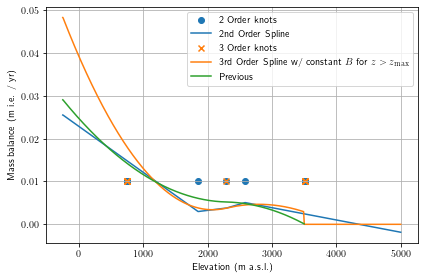

In [4]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharex=True)

old_z = np.loadtxt('../include/fitpack/test/data/x_vec.dat')
old_b = np.loadtxt('../include/fitpack/test/data/y_vec.dat')

# ax.plot(0, 0, alpha=0.0)
# ax.scatter(MB_new.Z, MB_new.B, c=MB_new.B, alpha=0.0)

marker = ['o', 'x']
labels = ['2nd Order Spline', r'3rd Order Spline w/ constant $B$ for $ z > z_{\rm max}$']
for i, (k, s) in enumerate([(2,2500), (3,3000)]): 
    
    if i == 1: 
        w     = None
        tck   = interpolate.splrep(x_, y_, w=w, k=k, s=s)
        z_max = 3500
        cubic = constant_spline(z_full, tck, z_max)
    else: 
        w     = None
        tck   = interpolate.splrep(x_, y_, w=w, k=k, s=s)
        cubic = interpolate.splev(z_full, tck)    
    
    ax.scatter(tck[0], np.ones(tck[0].shape)*0.01, marker=marker[i], label=f'{i+2} Order knots')
    ax.plot(z_full, np.gradient(cubic, z_full), label=labels[i])

ax.plot(old_z, np.gradient(old_b, old_z), label='Previous')
ax.set_ylabel('Mass balance (m i.e. / yr)')
ax.set_xlabel('Elevation (m a.s.l.)')
ax.grid(which='major')

ax.legend()
plt.tight_layout()
# fig.savefig('/Users/andrewnolan/Desktop/splines_ddz.png', dpi=300, bbox_inches='tight', facecolor='w')

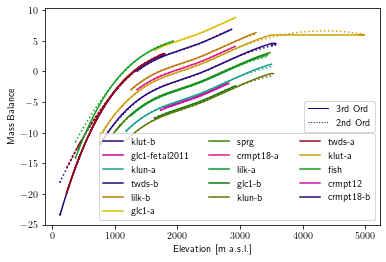

In [5]:
import glob
from matplotlib.lines import Line2D

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

mpl = plt.matplotlib
colors = ['#28047c', '#bc07a1', '#10a088', 
          '#1c0672', '#bc7a09', '#dbbe00', 
          '#388402', '#e21687', '#04992e', 
          '#097a13', '#607704', '#960721', 
          '#cc9e0a', '#10a020', '#d310a6']

mpl.rcParams['axes.prop_cycle'] = (mpl.cycler(color=colors) *\
                                   mpl.cycler(linestyle=['-', ':']))

# third order
k    = 3
s    = 3000
w    = None
tck3 = interpolate.splrep(x_, y_, w=None, k=k, s=s)
# second order
k    = 2
s    = 2500
w    = None
tck2 = interpolate.splrep(x_, y_, w=w, k=k, s=s)

fig, ax = plt.subplots()

paths = glob.glob('../input_data/topography/*_surf.dat')
label = [fp.split('/')[-1].split('_')[0] for fp in paths]

for i, fp in enumerate(paths): 
    n = rs.random() * 6 * rs.choice([-1,1])
    
    z_s = np.loadtxt(fp)[:,1]    
    b_i = constant_spline(z_s, tck3) + n
    
    b_2 = interpolate.splev(z_s, tck2) + n
    
    label = [fp.split('/')[-1].split('_')[0] for fp in paths]
    ax.plot(z_s, b_i, label=label[i])
    ax.plot(z_s, b_2)

    
custom_lines = [Line2D([0], [0], color=colors[0], lw=1, ls='-'),
                Line2D([0], [0], color=colors[0], lw=1, ls=':')]

leg1 = ax.legend(ncol=3); ax.add_artist(leg1)

ax.legend(custom_lines, ["3rd Ord", "2nd Ord"], loc=5)
ax.set_ylabel('Mass Balance')
ax.set_xlabel('Elevation [m a.s.l.]')
# fig.savefig("/Users/andrewnolan/Desktop/3rd_order_per.png", dpi=300, bbox_inches='tight', facecolor='w')